In [2]:
import tensorflow as tf

In [5]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/bean"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 12068 files belonging to 4 classes.


In [6]:
classes = training_set.class_names
classes

['bean_angular_leaf_spot', 'bean_healthy', 'bean_rust', 'soyabean_healthy']

In [7]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size

In [8]:
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

378
302
76


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [13]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [14]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/15
  1/302 [..............................] - ETA: 8:39 - loss: 1.6605 - categorical_accuracy: 0.2188

2025-05-02 04:12:06.989346: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.
2025-05-02 04:12:07.005051: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 156905472 exceeds 10% of free system memory.


  2/302 [..............................] - ETA: 52s - loss: 1.1014 - categorical_accuracy: 0.5625 

2025-05-02 04:12:07.218155: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.
2025-05-02 04:12:07.227896: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 156905472 exceeds 10% of free system memory.
2025-05-02 04:12:07.394699: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.


302/302 [==============================] - 63s 203ms/step - loss: 0.0716 - categorical_accuracy: 0.9743 - val_loss: 0.0288 - val_categorical_accuracy: 0.9892 - lr: 0.0010
Epoch 2/15
302/302 [==============================] - 61s 202ms/step - loss: 0.0233 - categorical_accuracy: 0.9913 - val_loss: 0.0246 - val_categorical_accuracy: 0.9900 - lr: 0.0010
Epoch 3/15
302/302 [==============================] - 65s 215ms/step - loss: 0.0124 - categorical_accuracy: 0.9953 - val_loss: 0.0292 - val_categorical_accuracy: 0.9867 - lr: 0.0010
Epoch 4/15
302/302 [==============================] - 63s 209ms/step - loss: 0.0074 - categorical_accuracy: 0.9982 - val_loss: 0.0235 - val_categorical_accuracy: 0.9917 - lr: 0.0010
Epoch 5/15
302/302 [==============================] - 64s 211ms/step - loss: 0.0050 - categorical_accuracy: 0.9984 - val_loss: 0.0262 - val_categorical_accuracy: 0.9896 - lr: 0.0010
Epoch 6/15
302/302 [==============================] - 64s 213ms/step - loss: 0.0023 - categorical_acc

In [16]:
train_loss,train_acc = model.evaluate(train_ds)

302/302 [==============================] - 69s 228ms/step - loss: 0.0034 - categorical_accuracy: 0.9994


In [17]:
val_loss,val_acc=model.evaluate(val_ds)

76/76 [==============================] - 14s 165ms/step - loss: 0.0231 - categorical_accuracy: 0.9921


In [18]:
model.save("trained_model_bean.keras")

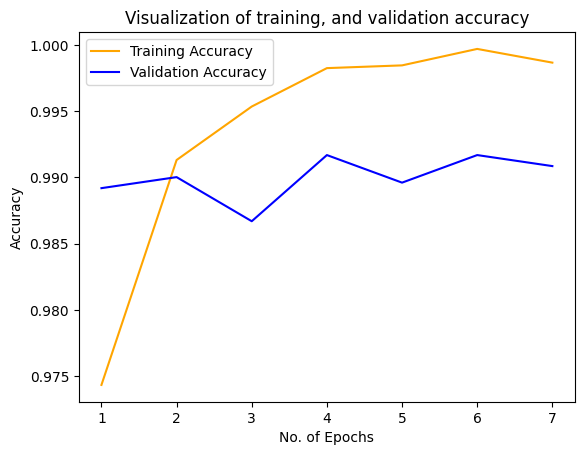

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
epochs=[i for i in range(1,8)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 424ms/step
Predicted class: bean_rust


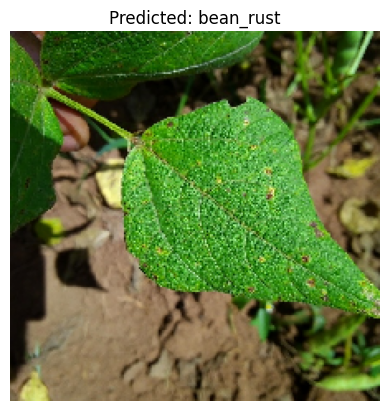

In [22]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions)]

    print(f"Predicted class: {predicted_class}")
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

from tensorflow.keras.preprocessing import image
import numpy as np
predict_image("/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/bean/bean_rust/bean_bean_rust_test.1.jpg")